In [361]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import *
from numpy.fft import fft,ifft,rfft,irfft
import scipy.signal as sig
from gwpy.timeseries import TimeSeries

Here's some data that sees the caduceus / raygun noise.

In [242]:
chan='L1:LSC-POP_A_RF9_I_ERR_DQ'
st=1162024217
dur=600

In [243]:
data=TimeSeries.fetch(chan,st,st+dur)

In [244]:
srate=data.sample_rate.value

The functions below take a short segment of data, do a zero-padded FFT (to do some extra smoothing), then find the largest peak above and below 120 Hz.

In [363]:
twid=int(srate) # Length of short spectra
zpadsec=8 # Length (sec) for oversampled FFT
zpadwid=int(srate*zpadsec)

win1=sig.hann(twid)
def myfft(data,tt):
    idx=int(tt*srate)-twid/2
    tmp=zeros(int(zpadsec*srate))
    tmp[:twid]=win1*data.value[idx:idx+twid]
    tmp=rfft(tmp)
    return tmp[100*zpadsec:140*zpadsec]

def track_lines(data,tt):
    fft1=myfft(data,tt)
    i1=abs(fft1[:20*zpadsec+1]).argmax()
    i2=abs(fft1[20*zpadsec:]).argmax()+20*zpadsec
    return (tt,i1/float(zpadsec)+100.,i2/float(zpadsec)+100) #,fft1[i1],fft1[i2])

Take the FFT and find peaks every quarter of a second.

In [364]:
tst=array([track_lines(data,tt) for tt in arange(1,dur-1,0.25)])

To make the spectrogram look nice, we'll do some bandpassing. This is left over from my previous attempt to do a Hilbert transform and get the phase directly, but I like the results.

In [262]:
filt=sig.firwin(int(8*srate),[105./nyq,135./nyq],window='hann',pass_zero=False)
filt.resize(len(data))
ffilt=abs(rfft(filt))

In [253]:
fdata=ffilt*rfft(data.detrend().value)
fdata[0]=0.
newdata=TimeSeries(irfft(fdata)[int(4*srate):-int(4*srate)],sample_rate=srate)

(100, 140)

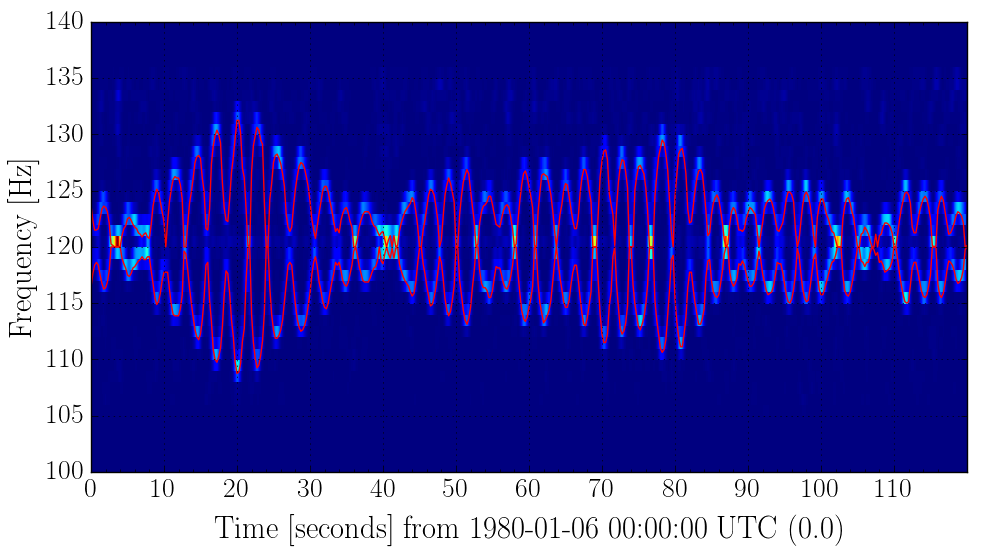

In [264]:
p1=newdata[:int(srate*120)].spectrogram2(1,0.98).plot()
plt.plot(tst[:,0]-4,tst[:,1],c='r')
plt.plot(tst[:,0]-4,tst[:,2],c='r')
#p1.gca().set_yscale('log')
p1.gca().set_ylim(100,140)

Now we look at the scattered light arches in a related degree of freedom, SRCL, to see if they're related to the raygun.

In [352]:
data2=TimeSeries.fetch('L1:LSC-SRCL_IN1_DQ',st,st+dur)

In [353]:
srate2=data2.sample_rate.value
nyq2=srate2/2.
filt2=sig.firwin(int(8*srate2),[4./nyq2,30./nyq2],window='hann',pass_zero=False)
filt2.resize(len(data2))
ffilt2=abs(rfft(filt2))

In [354]:
fdata2=ffilt2*rfft(data2.detrend().value)
fdata2[0]=0.
newdata2=TimeSeries(irfft(fdata2[:1+512*int(data2.duration.value)])[4*1024:-4*1024],sample_rate=1024)

In [357]:
sgram2=newdata2.spectrogram2(1,0.95)

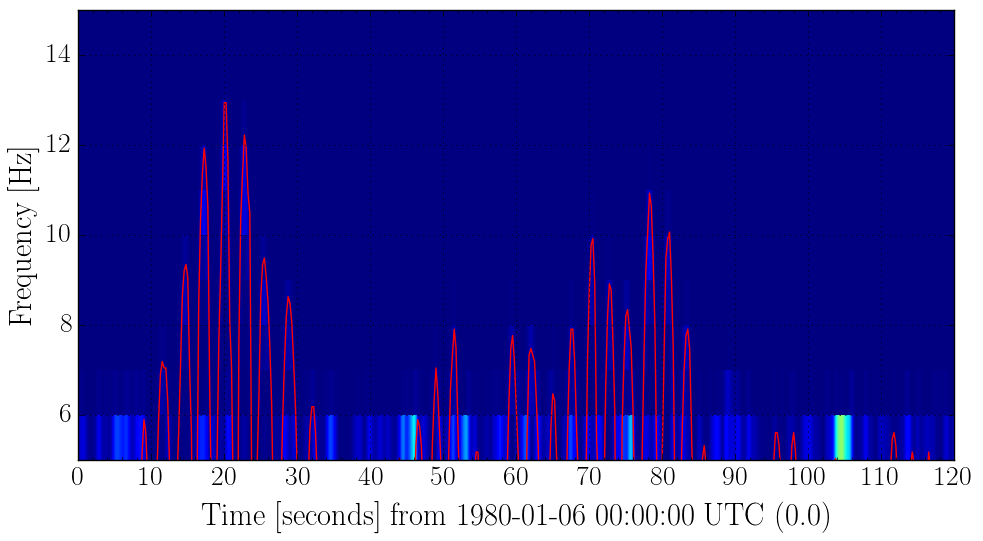

In [359]:
p1=sgram2.plot()
plt.plot(tst[:,0]-4,1.15*(tst[:,2]-120),c='r')
#p1.gca().set_yscale('log')
p1.gca().set_ylim(5,15)
p1.gca().set_xlim(0,120)

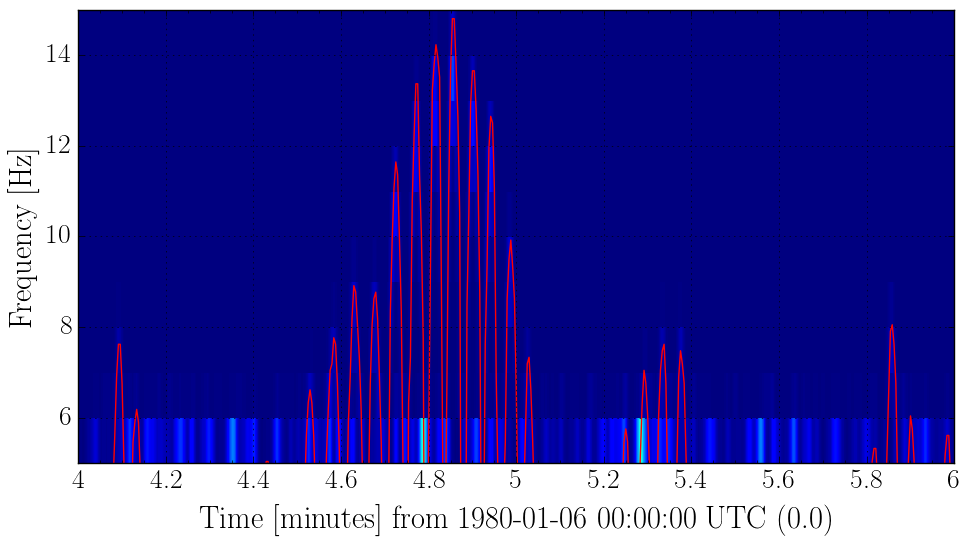

In [367]:
p1=sgram2.plot()
plt.plot(tst[:,0]-4,1.15*(tst[:,2]-120),c='r')
#p1.gca().set_yscale('log')
p1.gca().set_ylim(5,15)
p1.gca().set_xlim(240,360)

Yep, the scattered light looks to be very closely related to the raygun noise. Probably some mirror is moving, and some of the light that's getting scattered is 'tagged' with 120 Hz noise from somewhere.